<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#LyricsManager.py" data-toc-modified-id="LyricsManager.py-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LyricsManager.py</a></span></li><li><span><a href="#MoodyLyrics-issue" data-toc-modified-id="MoodyLyrics-issue-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MoodyLyrics issue</a></span></li><li><span><a href="#New-features" data-toc-modified-id="New-features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>New features</a></span><ul class="toc-item"><li><span><a href="#Dataset-Stats" data-toc-modified-id="Dataset-Stats-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Dataset Stats</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Feature Selection</a></span><ul class="toc-item"><li><span><a href="#Extra-test-set" data-toc-modified-id="Extra-test-set-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Extra test set</a></span></li></ul></li><li><span><a href="#Artificial-Neural-Network" data-toc-modified-id="Artificial-Neural-Network-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Artificial Neural Network</a></span></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#SVM" data-toc-modified-id="SVM-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>SVM</a></span></li><li><span><a href="#Gradient-Boost" data-toc-modified-id="Gradient-Boost-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Gradient Boost</a></span></li><li><span><a href="#Naive-Bayesian-Classifier" data-toc-modified-id="Naive-Bayesian-Classifier-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Naive Bayesian Classifier</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In [161]:
import spacy
import os
import sys

import itertools

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from utils.datasets import load_dataset_from_path, split_train_validation

emotion_labels = ['happy', 'sad', 'angry', 'relaxed']

In [162]:
# Read extra test set
extra_test_path = './datasets/extra_test.csv'
extra_test = pd.read_csv(extra_test_path)

In [163]:
extra_test.columns = ['ID', 'ARTIST', 'SONG_TITLE', 'LYRICS_VECTOR', 'TITLE_VECTOR', 
                   'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
                   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
                   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
                   'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
                   'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
                   'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
                   'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES', 
                   'X_FREQUENCIES', 'SPACE_FREQUENCIES', 'EMOTION']

In [164]:
def plot_confusion_matrix(cm, classes = emotion_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Introduction
**Previously on Sara&Mario project**: 
<ol>
    <li>*MoodyLyrics* stats analysis</li>
    <li>Lyrics classification using the main classifiers</li>
    <li>Emotion classification by just considering the song title</li> 
</ol>
Now, following the last meeting discussion we: 
<ol>
    <li>Wrote a script to create the dataset *SpotifyURI*, *List of PlaylistIDs*, *MoodyLyric_Emotion*</li>
    <li>Wrote a script to detect all duplicated songs in MoodyLyrics to fill a bug report</li>
    <li>Added new features for the classification task</li>
</ol>

# LyricsManager.py
After downloading the Spotify RecSys Challenge dataset we wrote a script that: <br>
<ul>
    <li>Given as input: the *Spotify playlist dataset folder*, and an output folder, creates a data structure to store for each song:<br>
        <*SpotifyURI*, *PlaylistIDs*, *TrackInformation*, *Emotion*><br>
        where: 
            <ul>
                <li>*SpotifyURI* is the songID</li>
                <li>*PlaylistsIDs* is the list of playlist in which the song appear</li>
                <li>*TrackInformation* is the list of information taken from Spotify dataset</li>
                <li>*Emotion* is an optional field, present only if the song is also contained in the MoodyLyrics dataset, that contains the emotion label for the song
    </li>
            </ul>
      <li>Can load Spotify songs datastructure (if already existing)</li>
            <li>Given as input a SpotifyURI it can download lyrics from lyricwikia</li>
</ul>

# MoodyLyrics issue
New week we detected duplicate information in MoodyLyrics. Now we can generate a .csv file capable of reporting those duplicates.

Now it's time to fill a bug.

# New features
Starting from MoodyLyrics we are going to create a new dataset with a lot of new features. <br>
<ul>
    <li>**Title_vector**</li>
    <li>**Lyric_vector**</li>
    <li>**%Rhymes**:<br> defined as the percentage of the number of rhymes over the number of total lines. A rhyme is defined as a rhyme between two following lines.</li>
    <li>**%Past_tense_verbs**:<br> defined as the the percentage of the number of past tense verbs over the total number of verbs.</li>
    <li>**%Present_tense_verbs**:<br>  defined as the the percentage of the number of present tense verbs over the total number of verbs.</li>
    <li>**%Future_tense_verbs**:<br>  defined as the the percentage of the number of future tense verbs over the total number of verbs, where future is just will + base form.</li>
    <li>**%ADJ**:<br> Percentage of adjectives over the total number of words.</li>
    <li>**%ADP**:<br> Percentage of adpositions (e.g. in, to, during) over the total number of words.</li>
    <li>**%ADV**:<br> Percentage of adverbs (e.g. very, tomorrow, down, where, there) over the total number of words.</li>
    <li>**%AUX**:<br> Percentage of auxiliaries (e.g. is, has (done), will (do), should (do)) over the total number of words.</li>
    <li>**%INTJ**:<br> Percentage of interjections (e.g. psst, ouch, bravo, hello) over the total number of words.</li>
    <li>**%NOUN**:<br> Percentage of nouns over the total number of words.</li>
    <li>**%NUM**:<br> Percentage of numerals over the total number of words.</li>
    <li>**%PRON**:<br> Percentage of pronouns (e.g. I, you, he, she, myself, themselves, somebody,...) over the total number of words.</li> 
    <li>**%PROPN**:<br> Percentage of proper nouns (e.g. Mary, John) over the total number of words.</li>
    <li>**%PUNCT**:<br> Percentage of puntuctuation (e.g. ., (, ), ?) over the total number of words.</li>
    <li>**%VERB**:<br> Percentage of verbs over the total number of words.</li>
    <li>**Selfish_degree**:<br> Percentage of 'I' pronouns over the total number of pronouns</li>
    <li>**%Echoism**:<br> Percentage of echoism over the total number of words, where an echoism is either a sequence of two subsequent repeated words or the repetition of a vowel in a word. </li>
    <li>**%Duplicates**:<br> Percentage of duplicate words over the total number of words</li>
    <li>**isTitleInLyric**:<br> Boolean, true if the title string is also a substring of the lyric</li>
    <li>**positive sentiment**:<br> Degree of positive sentiment expressed toward the argument</li>
    <li>**neutral sentiment**:<br> Degree of neutral sentiment expressed toward the argument</li>
    <li>**negative sentiment**:<br> Degree of negative sentiment expressed toward the argument</li>
</ul>

The sentiment analysis was done using the API available at this link [http://text-processing.com/](http://text-processing.com/). This API was trained on both twitter sentiment as well as movie reviews from the [data sets created by Bo Pang and Lillian Lee](http://www.cs.cornell.edu/people/pabo/movie-review-data/) using nltk-trainer

## Dataset Stats

In [165]:
import pandas as pd

In [166]:
dataset = pd.read_csv('./datasets/moodylyrics_featurized.csv')
"""
dataset.columns = ['ID', 'ARTIST', 'SONG_TITLE', 'LYRICS_VECTOR', 'TITLE_VECTOR', 
                   'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
                   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
                   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
                   'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
                   'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
                   'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
                   'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES', 
                   'X_FREQUENCIES', 'SPACE_FREQUENCIES', 
                   'SENTIMENT_POS', 'SENTIMENT_NEUTRAL', 'SENTIMENT_NEG',
                   'EMOTION']
"""                   

In [167]:
useless_columns = [ 'ID','ARTIST', 'SONG_TITLE', 'EMOTION', 'X_FREQUENCIES', 'SPACE_FREQUENCIES']

In [168]:
print(len(dataset.columns))

35


In [169]:
dataset.head(5)

,ID,ARTIST,SONG_TITLE,LYRICS_VECTOR,TITLE_VECTOR,LINE_COUNT,WORD_COUNT,ECHOISMS,SELFISH_DEGREE,DUPLICATE_LINES,...,PART_FREQUENCIES,PRON_FREQUENCIES,PROPN_FREQUENCIES,PUNCT_FREQUENCIES,SCONJ_FREQUENCIES,SYM_FREQUENCIES,VERB_FREQUENCIES,X_FREQUENCIES,SPACE_FREQUENCIES,EMOTION
0,0,.38 Special,Fantasy Girl,[-2.59583928e-02 1.46213636e-01 -2.40031540e-...,[-0.1325517 0.07027499 -0.353215 0.047058...,35,174,0.0,0.291667,0.091954,...,0.045977,0.137931,0.000000,0.051724,0.0,0.0,0.241379,0.0,0.0,relaxed
1,1,.38 Special,Second Chance,[-1.19381584e-02 2.30911389e-01 -1.93970740e-...,[-2.17199996e-02 3.36335003e-01 -1.79910004e-...,50,318,0.0,0.368421,0.066038,...,0.031447,0.182390,0.000000,0.006289,0.0,0.0,0.345912,0.0,0.0,happy
2,2,22-20s,Hold On,[ 5.15404232e-02 1.07047103e-01 -2.46115208e-...,[-9.10529941e-02 1.45800002e-02 -2.31949985e-...,38,217,0.0,0.461538,0.142857,...,0.133641,0.119816,0.000000,0.000000,0.0,0.0,0.313364,0.0,0.0,angry
3,3,3 Inches Of Blood,Trial Of Champions,[-7.87018538e-02 7.39747062e-02 -8.28025416e-...,[-3.40596698e-02 7.27466643e-02 2.60249972e-...,33,179,0.0,0.000000,0.000000,...,0.039106,0.055866,0.011173,0.011173,0.0,0.0,0.245810,0.0,0.0,angry
4,4,3 of Hearts,Is It Love,[-9.74312518e-03 2.82311559e-01 -1.53461650e-...,[ 1.86306313e-02 4.64353323e-01 -1.01861566e-...,45,252,0.0,0.223881,0.130952,...,0.003968,0.269841,0.000000,0.166667,0.0,0.0,0.305556,0.0,0.0,happy


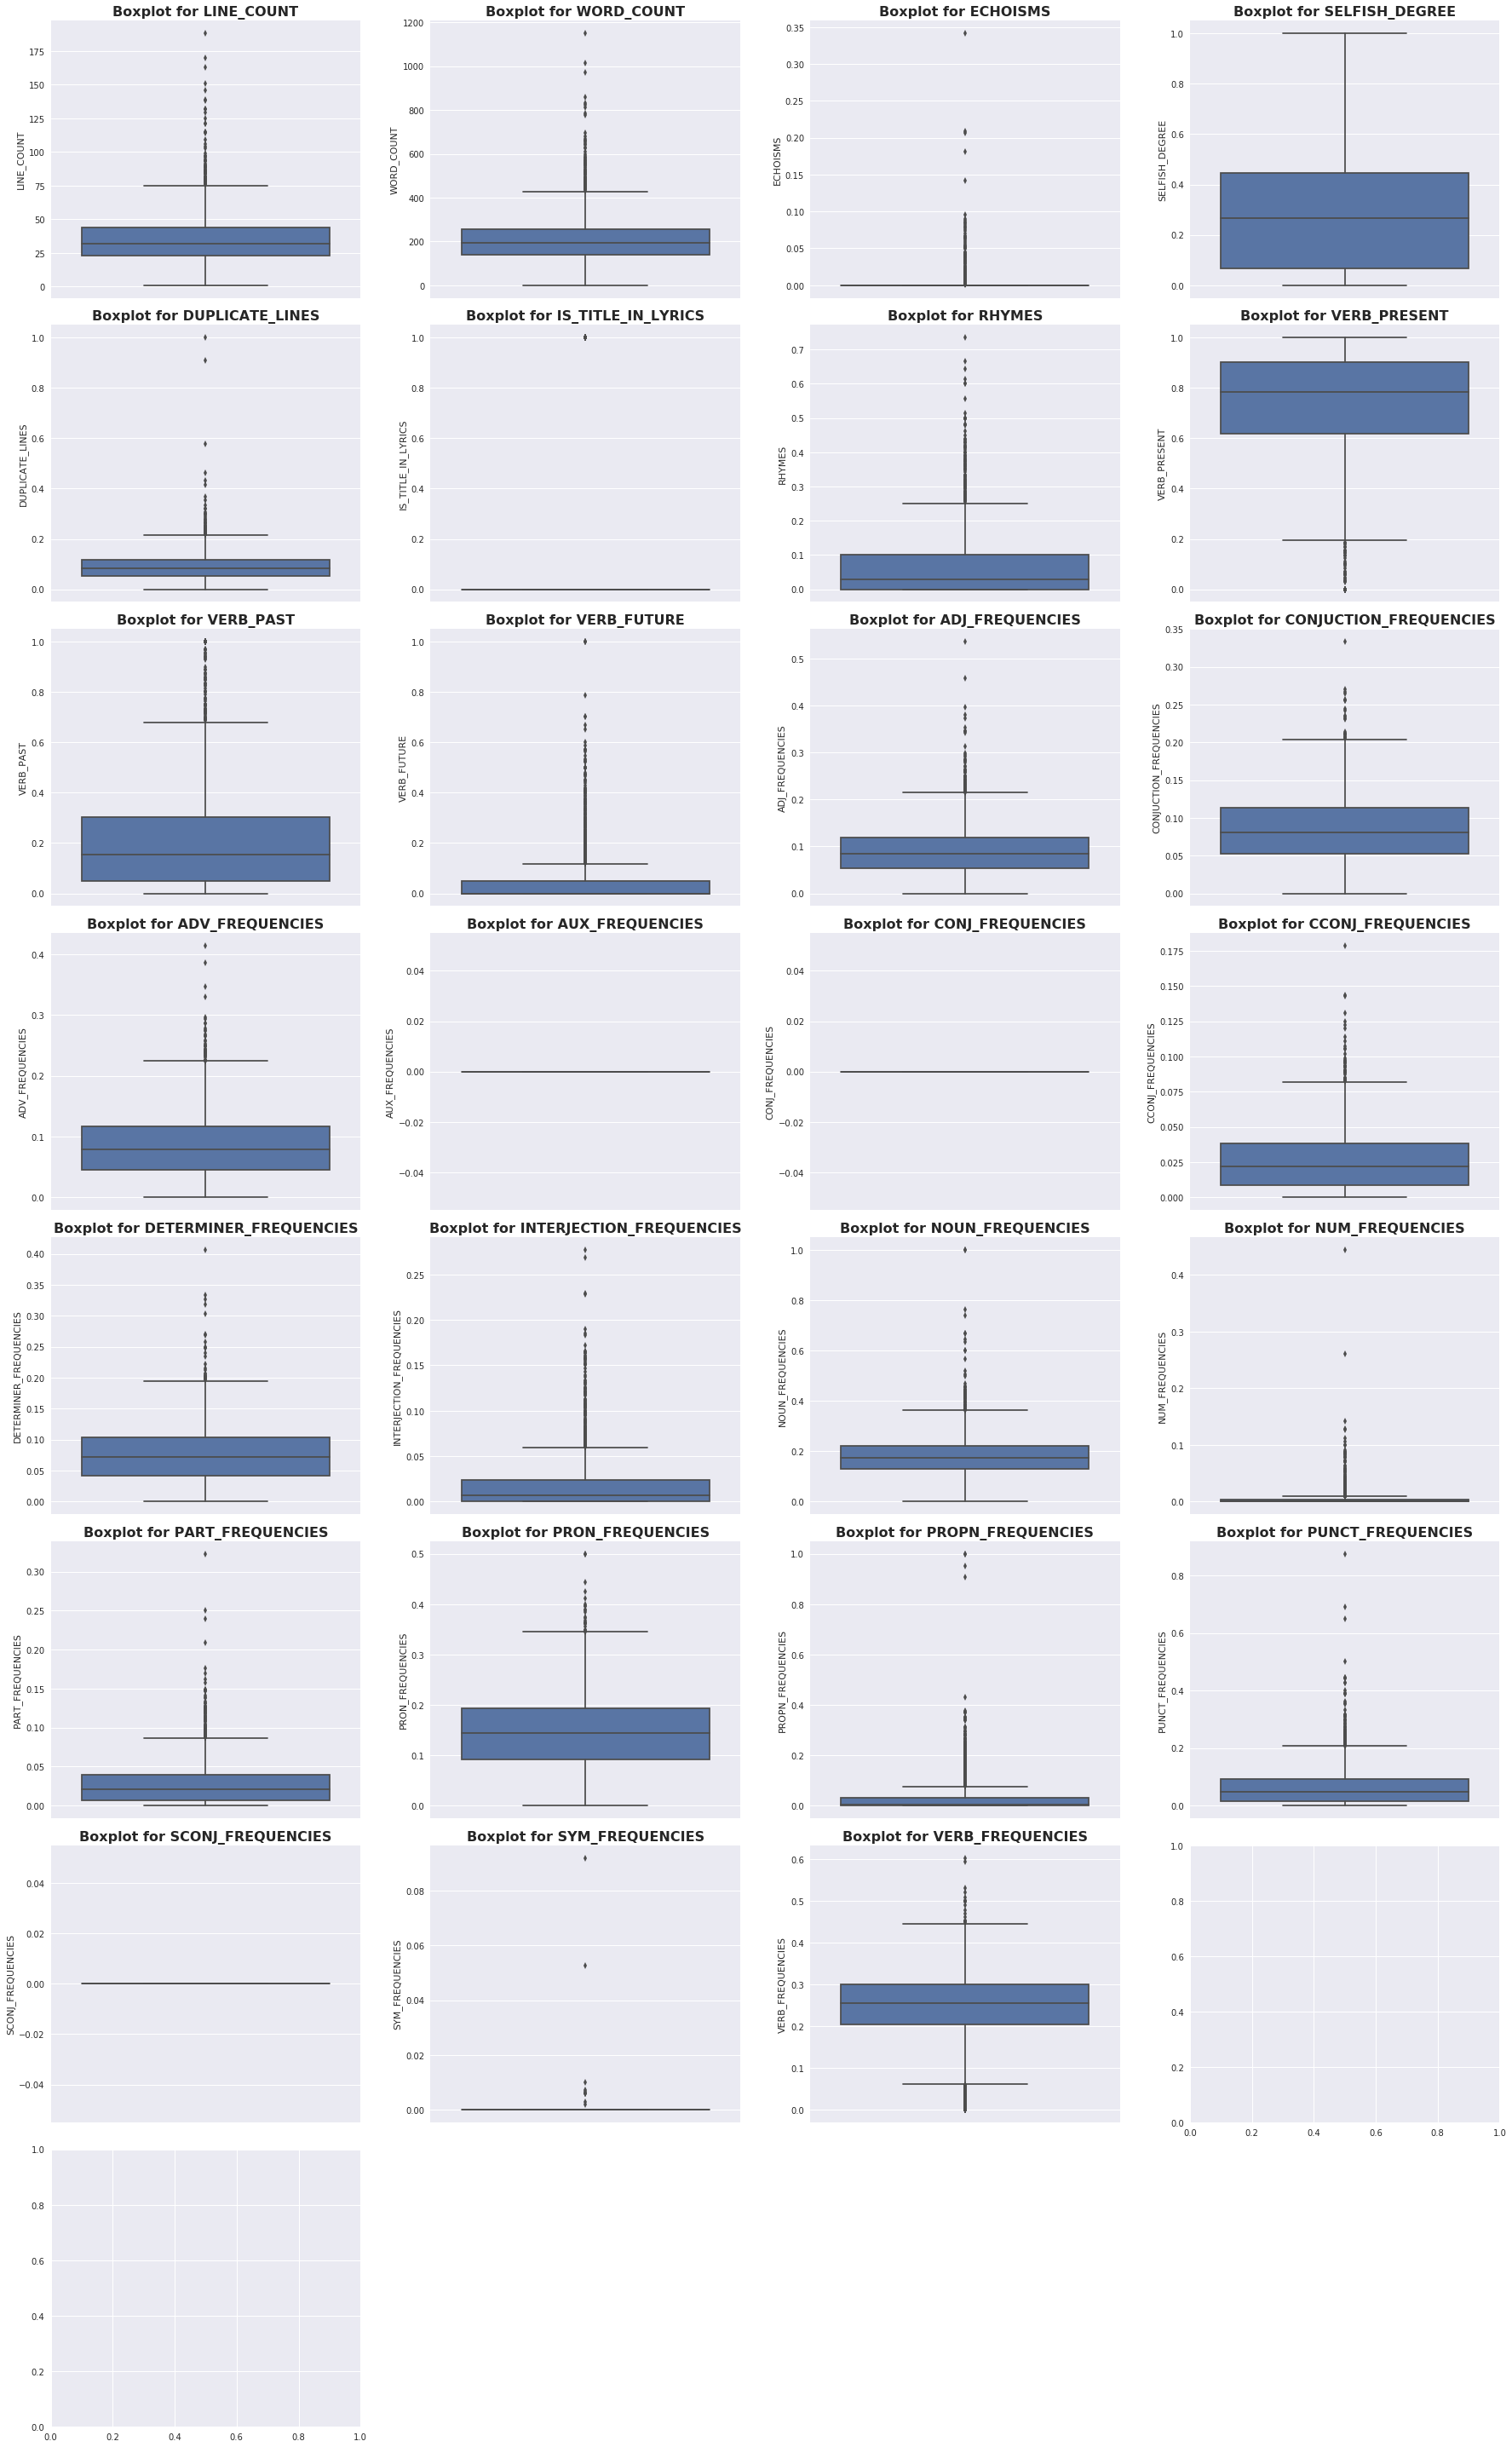

In [12]:
tmp_df = dataset.drop(useless_columns + ['LYRICS_VECTOR', 'TITLE_VECTOR'],axis=1)

f, axarr = plt.subplots(8, 4, figsize=(25,40))
k = 0
for feature in tmp_df.columns:
    (i, j) = divmod(k, 4)
    axarr[i,j] = sns.boxplot(y=tmp_df[feature], ax=axarr[i,j])
    axarr[i,j].set_title('Boxplot for {}'.format(feature), fontsize=16, weight='bold')
    k += 1
plt.tight_layout()
f.delaxes(axarr[-1,-1])
f.delaxes(axarr[-1,-2])
f.delaxes(axarr[-1,-3])

## Feature Selection

In [170]:
selected_columns = [
   'LYRICS_VECTOR',
   'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT_POS', 'SENTIMENT_NEUTRAL', 'SENTIMENT_NEG',
   'EMOTION'
]

In [171]:
dataset = dataset[selected_columns]
extra_test = extra_test[selected_columns]

In [172]:
tmp_df = dataset.drop(['EMOTION'], axis=1)
X_vect = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == str:
            field = field[1:-1].split()
            sub_list += [float(x.replace('\n','')) for x in field]
        else:
            sub_list.append(field)
    X_vect.append(np.array(sub_list))
X_vect = np.array(X_vect)

In [173]:
y = dataset['EMOTION'].as_matrix().T

In [174]:
print(X_vect.shape)
print(y.shape)

(2452, 310)
(2452,)


In [175]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size = 0.2, random_state = 0)

### Extra test set

In [176]:
tmp_df = extra_test.drop(['EMOTION'], axis=1)
X_test_extra = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == str:
            field = field[1:-1].split()
            sub_list += [float(x.replace('\n','')) for x in field]
        else:
            sub_list.append(field)
    X_test_extra.append(np.array(sub_list))
X_test_extra = np.array(X_test_extra)

In [177]:
y_test_extra = extra_test['EMOTION'].as_matrix().T

## Artificial Neural Network

In [205]:
#2 y_nn should be a vector (len(X_vect),4), with a 1 in the right class
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_nn = np_utils.to_categorical(encoded_Y)

#3 Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# we need to scale because we don't want one feature to predomine the others
# Standardize features by removing the mean and scaling to unit variance
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Using TensorFlow backend.


In [206]:
#1 Importing the Keras libraries and packages
import keras
# Sequential module is required to initialize our ANN
from keras.models import Sequential
# Dense module is required to create the layers
from keras.layers import Dense, Dropout
    
def build_ann(optimizer='adam', input_size=X_vect.shape[1]):
    classifier = Sequential()
    #2 Adding first hidden layer
    classifier.add(Dense(units = 60, kernel_initializer = 'random_normal', activation = 'sigmoid', input_dim = input_size))
    classifier.add(Dropout(0.5))
    
    #2 Adding second hidden layer
    classifier.add(Dense(units = 60, kernel_initializer = 'random_normal', activation = 'sigmoid', input_dim = input_size))
    classifier.add(Dropout(0.5))
   

    # Adding output layer
    classifier.add(Dense(units = 4, kernel_initializer = 'random_normal', activation = 'softmax'))

    #3 Compiling the ANN
    classifier.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return classifier

In [207]:
from keras.wrappers.scikit_learn import KerasClassifier

keras_classifier = KerasClassifier(build_fn=build_ann)
parameters = {'batch_size': [256],
              'epochs': [100],
              'optimizer': ['adam']}
grid_search = GridSearchCV(estimator = keras_classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           verbose=0)
grid_search = grid_search.fit(X_train, y_train, verbose=0)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
best_classifier = grid_search.best_estimator_
print('Accuracy: %0.2f' % (best_accuracy*100))
print('Best parameters', best_parameters)

Epoch 1/100
1764/1764 [==============================] - 0s 178us/step - loss: 1.3951 - acc: 0.2749
Epoch 2/100
1764/1764 [==============================] - 0s 22us/step - loss: 1.3757 - acc: 0.2971
Epoch 3/100
1764/1764 [==============================] - 0s 25us/step - loss: 1.3661 - acc: 0.3146
Epoch 4/100
1764/1764 [==============================] - 0s 23us/step - loss: 1.3540 - acc: 0.3464
Epoch 5/100
1764/1764 [==============================] - 0s 24us/step - loss: 1.3379 - acc: 0.3662
Epoch 6/100
1764/1764 [==============================] - 0s 21us/step - loss: 1.3083 - acc: 0.4127
Epoch 7/100
1764/1764 [==============================] - 0s 25us/step - loss: 1.2719 - acc: 0.4575
Epoch 8/100
1764/1764 [==============================] - 0s 24us/step - loss: 1.2441 - acc: 0.4722
Epoch 9/100
1764/1764 [==============================] - 0s 22us/step - loss: 1.1920 - acc: 0.5113
Epoch 10/100
1764/1764 [==============================] - 0s 22us/step - loss: 1.1357 - acc: 0.5346
Epoch 11

1765/1765 [==============================] - 0s 20us/step - loss: 0.2926 - acc: 0.9048
Epoch 65/100
1765/1765 [==============================] - 0s 23us/step - loss: 0.2905 - acc: 0.9025
Epoch 66/100
1765/1765 [==============================] - 0s 23us/step - loss: 0.2944 - acc: 0.8958
Epoch 67/100
1765/1765 [==============================] - 0s 21us/step - loss: 0.2824 - acc: 0.9037
Epoch 68/100
1765/1765 [==============================] - 0s 22us/step - loss: 0.2964 - acc: 0.8992
Epoch 69/100
1765/1765 [==============================] - 0s 25us/step - loss: 0.2924 - acc: 0.9048
Epoch 70/100
1765/1765 [==============================] - 0s 23us/step - loss: 0.2847 - acc: 0.9031
Epoch 71/100
1765/1765 [==============================] - 0s 22us/step - loss: 0.2517 - acc: 0.9150
Epoch 72/100
1765/1765 [==============================] - 0s 25us/step - loss: 0.2757 - acc: 0.9093
Epoch 73/100
1765/1765 [==============================] - 0s 21us/step - loss: 0.2487 - acc: 0.9229
Epoch 74/100


1765/1765 [==============================] - 0s 24us/step - loss: 0.4309 - acc: 0.8527
Epoch 47/100
1765/1765 [==============================] - 0s 22us/step - loss: 0.4143 - acc: 0.8521
Epoch 48/100
1765/1765 [==============================] - 0s 23us/step - loss: 0.4083 - acc: 0.8646
Epoch 49/100
1765/1765 [==============================] - 0s 24us/step - loss: 0.4064 - acc: 0.8691
Epoch 50/100
1765/1765 [==============================] - 0s 20us/step - loss: 0.4091 - acc: 0.8550
Epoch 51/100
1765/1765 [==============================] - 0s 20us/step - loss: 0.3765 - acc: 0.8720
Epoch 52/100
1765/1765 [==============================] - 0s 20us/step - loss: 0.3881 - acc: 0.8748
Epoch 53/100
1765/1765 [==============================] - 0s 21us/step - loss: 0.3636 - acc: 0.8737
Epoch 54/100
1765/1765 [==============================] - 0s 22us/step - loss: 0.3717 - acc: 0.8799
Epoch 55/100
1765/1765 [==============================] - 0s 19us/step - loss: 0.3614 - acc: 0.8748
Epoch 56/100


1765/1765 [==============================] - 0s 31us/step - loss: 0.5487 - acc: 0.8193
Epoch 29/100
1765/1765 [==============================] - 0s 33us/step - loss: 0.5418 - acc: 0.8176
Epoch 30/100
1765/1765 [==============================] - 0s 32us/step - loss: 0.5214 - acc: 0.8136
Epoch 31/100
1765/1765 [==============================] - 0s 23us/step - loss: 0.5106 - acc: 0.8272
Epoch 32/100
1765/1765 [==============================] - 0s 29us/step - loss: 0.4828 - acc: 0.8436
Epoch 33/100
1765/1765 [==============================] - 0s 30us/step - loss: 0.4912 - acc: 0.8397
Epoch 34/100
1765/1765 [==============================] - 0s 31us/step - loss: 0.4583 - acc: 0.8453
Epoch 35/100
1765/1765 [==============================] - 0s 34us/step - loss: 0.4604 - acc: 0.8521
Epoch 36/100
1765/1765 [==============================] - 0s 33us/step - loss: 0.4449 - acc: 0.8465
Epoch 37/100
1765/1765 [==============================] - 0s 28us/step - loss: 0.4522 - acc: 0.8527
Epoch 38/100


1765/1765 [==============================] - 0s 32us/step - loss: 1.1387 - acc: 0.5326
Epoch 11/100
1765/1765 [==============================] - 0s 33us/step - loss: 1.0838 - acc: 0.5552
Epoch 12/100
1765/1765 [==============================] - 0s 25us/step - loss: 1.0333 - acc: 0.5722
Epoch 13/100
1765/1765 [==============================] - 0s 36us/step - loss: 0.9888 - acc: 0.5853
Epoch 14/100
1765/1765 [==============================] - 0s 28us/step - loss: 0.9450 - acc: 0.6119
Epoch 15/100
1765/1765 [==============================] - 0s 33us/step - loss: 0.9117 - acc: 0.6346
Epoch 16/100
1765/1765 [==============================] - 0s 30us/step - loss: 0.8788 - acc: 0.6476
Epoch 17/100
1765/1765 [==============================] - 0s 29us/step - loss: 0.8655 - acc: 0.6487
Epoch 18/100
1765/1765 [==============================] - 0s 25us/step - loss: 0.8380 - acc: 0.6550
Epoch 19/100
1765/1765 [==============================] - 0s 28us/step - loss: 0.7960 - acc: 0.6963
Epoch 20/100


1765/1765 [==============================] - 0s 24us/step - loss: 0.2291 - acc: 0.9246
Epoch 93/100
1765/1765 [==============================] - 0s 22us/step - loss: 0.2351 - acc: 0.9241
Epoch 94/100
1765/1765 [==============================] - 0s 21us/step - loss: 0.2181 - acc: 0.9337
Epoch 95/100
1765/1765 [==============================] - 0s 21us/step - loss: 0.2243 - acc: 0.9229
Epoch 96/100
1765/1765 [==============================] - 0s 21us/step - loss: 0.2255 - acc: 0.9224
Epoch 97/100
1765/1765 [==============================] - 0s 23us/step - loss: 0.2267 - acc: 0.9184
Epoch 98/100
1765/1765 [==============================] - 0s 20us/step - loss: 0.2099 - acc: 0.9303
Epoch 99/100
1765/1765 [==============================] - 0s 20us/step - loss: 0.2225 - acc: 0.9235
Epoch 100/100
1765/1765 [==============================] - 0s 22us/step - loss: 0.2151 - acc: 0.9314
Epoch 1/100
1765/1765 [==============================] - 1s 311us/step - loss: 1.4408 - acc: 0.2306
Epoch 2/100


1765/1765 [==============================] - 0s 21us/step - loss: 0.2835 - acc: 0.9054
Epoch 75/100
1765/1765 [==============================] - 0s 22us/step - loss: 0.2923 - acc: 0.8969
Epoch 76/100
1765/1765 [==============================] - 0s 20us/step - loss: 0.2726 - acc: 0.9116
Epoch 77/100
1765/1765 [==============================] - 0s 22us/step - loss: 0.2765 - acc: 0.9071
Epoch 78/100
1765/1765 [==============================] - 0s 20us/step - loss: 0.2775 - acc: 0.9065
Epoch 79/100
1765/1765 [==============================] - 0s 20us/step - loss: 0.2716 - acc: 0.9099
Epoch 80/100
1765/1765 [==============================] - 0s 19us/step - loss: 0.2842 - acc: 0.9110
Epoch 81/100
1765/1765 [==============================] - 0s 21us/step - loss: 0.2645 - acc: 0.9059
Epoch 82/100
1765/1765 [==============================] - 0s 21us/step - loss: 0.2627 - acc: 0.9139
Epoch 83/100
1765/1765 [==============================] - 0s 20us/step - loss: 0.2673 - acc: 0.9088
Epoch 84/100


1765/1765 [==============================] - 0s 22us/step - loss: 0.3338 - acc: 0.8890
Epoch 57/100
1765/1765 [==============================] - 0s 24us/step - loss: 0.3295 - acc: 0.8844
Epoch 58/100
1765/1765 [==============================] - 0s 25us/step - loss: 0.3155 - acc: 0.8952
Epoch 59/100
1765/1765 [==============================] - 0s 20us/step - loss: 0.3196 - acc: 0.8924
Epoch 60/100
1765/1765 [==============================] - 0s 21us/step - loss: 0.3221 - acc: 0.8827
Epoch 61/100
1765/1765 [==============================] - 0s 23us/step - loss: 0.2985 - acc: 0.9020
Epoch 62/100
1765/1765 [==============================] - 0s 22us/step - loss: 0.3079 - acc: 0.8986
Epoch 63/100
1765/1765 [==============================] - 0s 21us/step - loss: 0.3036 - acc: 0.9031
Epoch 64/100
1765/1765 [==============================] - 0s 25us/step - loss: 0.3064 - acc: 0.8935
Epoch 65/100
1765/1765 [==============================] - 0s 22us/step - loss: 0.2997 - acc: 0.9014
Epoch 66/100


1765/1765 [==============================] - 0s 22us/step - loss: 0.4402 - acc: 0.8397
Epoch 39/100
1765/1765 [==============================] - 0s 21us/step - loss: 0.4453 - acc: 0.8465
Epoch 40/100
1765/1765 [==============================] - 0s 21us/step - loss: 0.4239 - acc: 0.8555
Epoch 41/100
1765/1765 [==============================] - 0s 22us/step - loss: 0.4024 - acc: 0.8652
Epoch 42/100
1765/1765 [==============================] - 0s 22us/step - loss: 0.3860 - acc: 0.8714
Epoch 43/100
1765/1765 [==============================] - 0s 21us/step - loss: 0.4040 - acc: 0.8691
Epoch 44/100
1765/1765 [==============================] - 0s 20us/step - loss: 0.3791 - acc: 0.8674
Epoch 45/100
1765/1765 [==============================] - 0s 21us/step - loss: 0.3783 - acc: 0.8646
Epoch 46/100
1765/1765 [==============================] - 0s 20us/step - loss: 0.3632 - acc: 0.8765
Epoch 47/100
1765/1765 [==============================] - 0s 21us/step - loss: 0.3602 - acc: 0.8839
Epoch 48/100


1765/1765 [==============================] - 0s 17us/step - loss: 0.7532 - acc: 0.6912
Epoch 21/100
1765/1765 [==============================] - 0s 18us/step - loss: 0.7443 - acc: 0.7048
Epoch 22/100
1765/1765 [==============================] - 0s 17us/step - loss: 0.7222 - acc: 0.7235
Epoch 23/100
1765/1765 [==============================] - 0s 16us/step - loss: 0.6997 - acc: 0.7133
Epoch 24/100
1765/1765 [==============================] - 0s 17us/step - loss: 0.6826 - acc: 0.7326
Epoch 25/100
1765/1765 [==============================] - 0s 18us/step - loss: 0.6687 - acc: 0.7388
Epoch 26/100
1765/1765 [==============================] - 0s 17us/step - loss: 0.6448 - acc: 0.7564
Epoch 27/100
1765/1765 [==============================] - 0s 17us/step - loss: 0.6267 - acc: 0.7728
Epoch 28/100
1765/1765 [==============================] - 0s 17us/step - loss: 0.6248 - acc: 0.7445
Epoch 29/100
1765/1765 [==============================] - 0s 17us/step - loss: 0.6100 - acc: 0.7632
Epoch 30/100


1765/1765 [==============================] - 0s 17us/step - loss: 0.2347 - acc: 0.9195
Epoch 84/100
1765/1765 [==============================] - 0s 17us/step - loss: 0.2440 - acc: 0.9241
Epoch 85/100
1765/1765 [==============================] - 0s 17us/step - loss: 0.2569 - acc: 0.9133
Epoch 86/100
1765/1765 [==============================] - 0s 18us/step - loss: 0.2218 - acc: 0.9297
Epoch 87/100
1765/1765 [==============================] - 0s 18us/step - loss: 0.2353 - acc: 0.9275
Epoch 88/100
1765/1765 [==============================] - 0s 17us/step - loss: 0.2387 - acc: 0.9173
Epoch 89/100
1765/1765 [==============================] - 0s 17us/step - loss: 0.2492 - acc: 0.9088
Epoch 90/100
1765/1765 [==============================] - 0s 17us/step - loss: 0.2135 - acc: 0.9365
Epoch 91/100
1765/1765 [==============================] - 0s 17us/step - loss: 0.2382 - acc: 0.9252
Epoch 92/100
1765/1765 [==============================] - 0s 18us/step - loss: 0.2235 - acc: 0.9241
Epoch 93/100


1961/1961 [==============================] - 0s 17us/step - loss: 0.2772 - acc: 0.9031
Epoch 66/100
1961/1961 [==============================] - 0s 20us/step - loss: 0.2808 - acc: 0.9062
Epoch 67/100
1961/1961 [==============================] - 0s 16us/step - loss: 0.2792 - acc: 0.9046
Epoch 68/100
1961/1961 [==============================] - 0s 17us/step - loss: 0.2755 - acc: 0.9077
Epoch 69/100
1961/1961 [==============================] - 0s 17us/step - loss: 0.2723 - acc: 0.9102
Epoch 70/100
1961/1961 [==============================] - 0s 17us/step - loss: 0.2753 - acc: 0.9082
Epoch 71/100
1961/1961 [==============================] - 0s 17us/step - loss: 0.2536 - acc: 0.9174
Epoch 72/100
1961/1961 [==============================] - 0s 17us/step - loss: 0.2493 - acc: 0.9204
Epoch 73/100
1961/1961 [==============================] - 0s 18us/step - loss: 0.2727 - acc: 0.9036
Epoch 74/100
1961/1961 [==============================] - 0s 16us/step - loss: 0.2611 - acc: 0.9113
Epoch 75/100


[[ 95   1   2   6]
 [  1 159   4   1]
 [  0   7  92   5]
 [ 10   1   5 102]]
Accuracy: 91.24


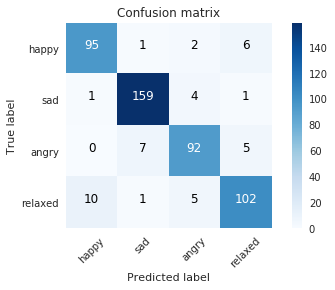

In [223]:
classifier = build_ann('adam')
classifier.fit(X_train, y_nn, batch_size = 256, epochs = 100, verbose=0)
y_pred = classifier.predict(X_test)

y_pred1 = np.argmax(y_pred,axis=1)

encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
y_nn_pred = np_utils.to_categorical(encoded_Y)
cm = confusion_matrix(y_pred1, y_nn_pred.argmax(axis=1))
plot_confusion_matrix(cm)
accuracy = (sum([cm[i,i] for i in range(len(cm))])) / len(y_nn_pred)
print('Accuracy: %0.2f' % (accuracy*100))

## Logistic Regression

In [178]:
from sklearn.linear_model import LogisticRegression
def evaluate_logreg(X_train, y_train, X_test, y_test):
    classifier = LogisticRegression(random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, emotion_labels)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

[[ 89   4   2  11]
 [  2 158   8   0]
 [  3  16  78   6]
 [ 17   2   4  91]]
Accuracy of logistic regression classifier on test set: 0.85


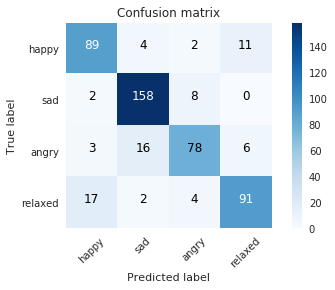

In [179]:
evaluate_logreg(X_train, y_train, X_test, y_test)

[[2 0 1 1]
 [0 3 0 1]
 [0 1 0 0]
 [2 0 1 2]]
Accuracy of logistic regression classifier on test set: 0.50


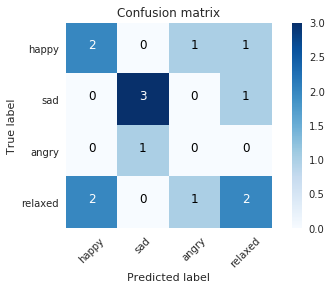

In [180]:
evaluate_logreg(X_train, y_train, X_test_extra, y_test_extra)

## SVM 

In [181]:
def parameters_grid_search(classifier, params, x, y, cv=10, verbose=False):
    """
    Grid Search to find best parameters for a certain classifier whose
    performances are evaluated using cross-validation
    """
    gs = GridSearchCV(classifier(), params, cv=cv, n_jobs=-1, verbose=verbose)
    gs.fit(x, y)    
    return (gs.best_estimator_, gs.best_params_)

In [182]:
from sklearn.svm import SVC

In [183]:
clf = SVC(C=10, kernel='rbf')
clf.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

[[ 23  72  10   1]
 [ 14 134  19   1]
 [ 11  74  17   1]
 [ 15  59  12  28]]
Accuracy of SVM classifier on test set: 0.41


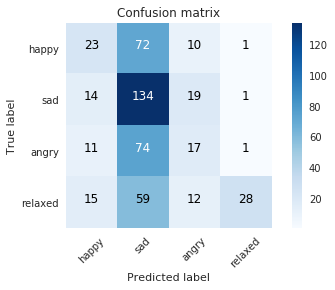

In [184]:
y_pred = clf.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
print('Accuracy of SVM classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

## Gradient Boost

In [192]:
from sklearn.ensemble import GradientBoostingClassifier

# Build model
clf = GradientBoostingClassifier(learning_rate=0.7, n_estimators=200)
# Evaluate accuracy
scores = cross_val_score(clf, X_vect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 1.96))

Accuracy: 0.83 (+/- 0.03)


In [193]:
clf = GradientBoostingClassifier(learning_rate=0.7, n_estimators=200)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

[[ 87   3   3  13]
 [  8 146  11   3]
 [  4  12  79   8]
 [ 20   5   5  84]]
Accuracy of SVM classifier on test set: 0.81


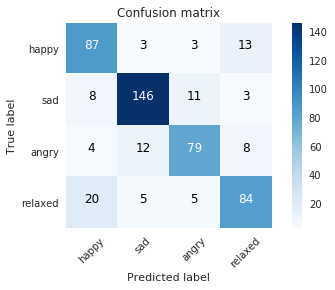

In [194]:
y_pred = clf.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
print('Accuracy of SVM classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

[[3 0 1 0]
 [1 2 0 1]
 [0 0 1 0]
 [3 1 1 0]]
Accuracy of Gradient Boosting classifier on extra test set: 0.43


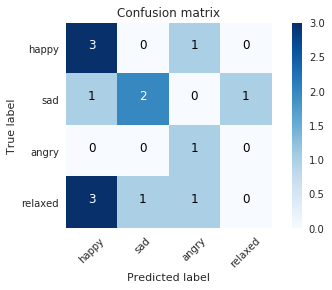

In [204]:
y_pred = clf.predict(X_test_extra)
plot_confusion_matrix(confusion_matrix(y_test_extra, y_pred))
print('Accuracy of Gradient Boosting classifier on extra test set: {:.2f}'.format(clf.score(X_test_extra, y_test_extra)))

## Naive Bayesian Classifier

In [197]:
from sklearn.naive_bayes import GaussianNB

In [198]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None)

[[ 84  10   5   7]
 [  3 137  20   8]
 [ 17  32  52   2]
 [ 61   8  15  30]]
Accuracy of Naive-Bayes classifier on test set: 0.62


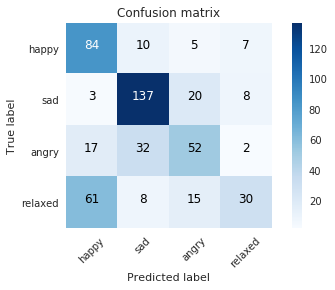

In [199]:
y_pred = clf.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
print('Accuracy of Naive-Bayes classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

[[3 0 1 0]
 [1 2 0 1]
 [0 0 1 0]
 [3 1 1 0]]
Accuracy of Naive-Bayes classifier on extra test set: 0.43


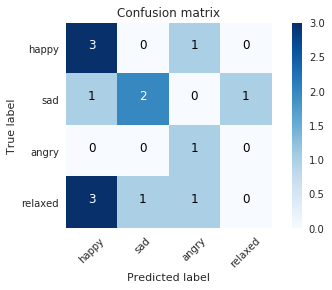

In [202]:
y_pred = clf.predict(X_test_extra)
plot_confusion_matrix(confusion_matrix(y_test_extra, y_pred))
print('Accuracy of Naive-Bayes classifier on extra test set: {:.2f}'.format(clf.score(X_test_extra, y_test_extra)))

# Conclusion
- The neural network is certainly the best classifier for our purpose
- We are always quite good at classifying sad songs but we often lack in performances while classifying other emotions